
   # Skin Disease Classification




   # Visualize the Dataset


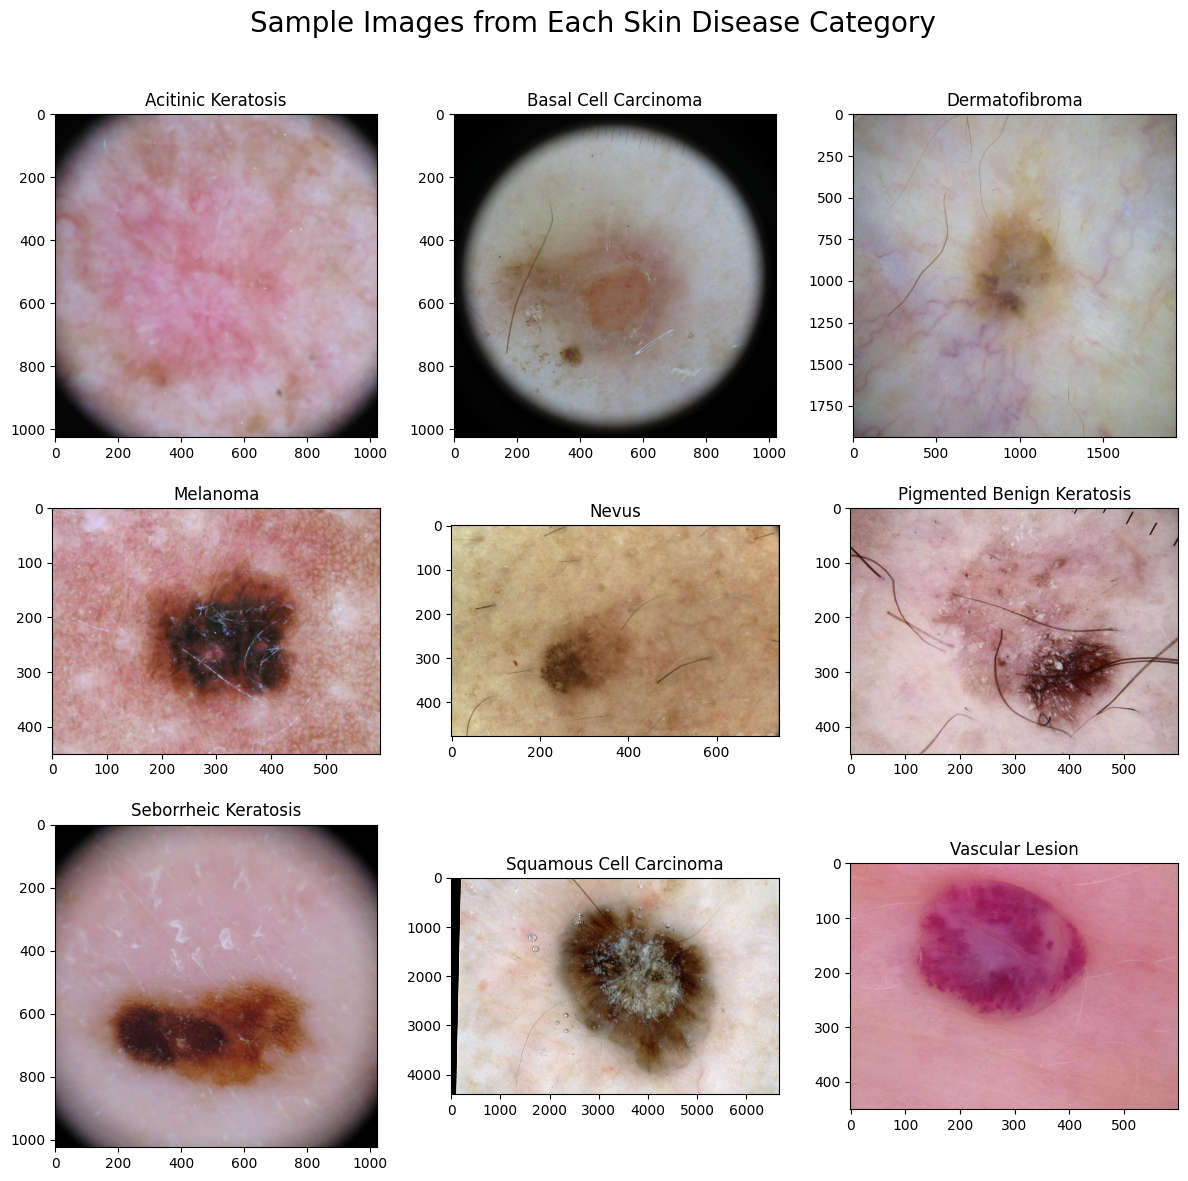

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the parent directory
parent_dir = 'Skin Cancer Dataset'

# Automatically retrieve the list of categories (subdirectories) from the parent directory
categories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Set up a grid for displaying images (3 rows, 3 columns to accommodate all categories)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Sample Images from Each Skin Disease Category", fontsize=20, color="#000000")
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop through each category and display one image
for i, category in enumerate(categories):
    category_dir = os.path.join(parent_dir, category)
    ax = axes[i // 3, i % 3]  # Determine position in the 3x3 grid

    try:
        # Retrieve one image file from the category
        image_files = [f for f in os.listdir(category_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:
            img_path = os.path.join(category_dir, image_files[0])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{category}", fontsize=12, color="#000000")
        else:
            ax.set_title(f"{category}\n(No Images Found)", fontsize=12, color="#FF0000")
            ax.axis('off')
    except Exception as e:
        print(f"Error loading image for category {category}: {e}")
        ax.set_title(f"{category}\n(Load Error)", fontsize=12, color="#FF0000")
        ax.axis('off')

# Hide any unused grid cells
for j in range(len(categories), 9):
    axes[j // 3, j % 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to leave space for the title
plt.show()

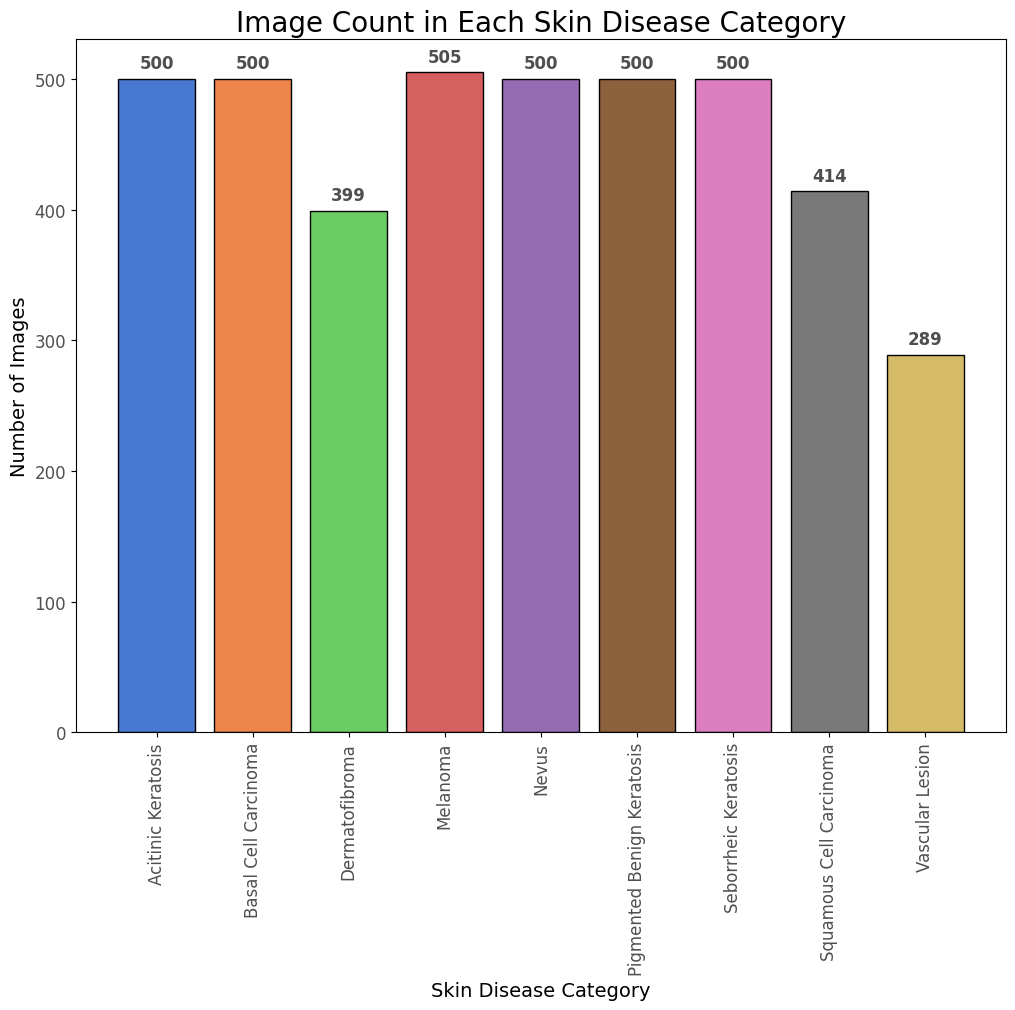

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Count images in each category
image_counts = []
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    count = len([img for img in os.listdir(category_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))])
    image_counts.append(count)

# Ensure only nine categories are displayed (if there are more than nine)
categories = categories[:9]
image_counts = image_counts[:9]

# Set color palette using seaborn's non-primary colors
palette = sns.color_palette("muted", len(categories))

# Create the bar chart
plt.figure(figsize=(12, 9))
bars = plt.bar(categories, image_counts, color=palette, edgecolor="#000")
plt.title("Image Count in Each Skin Disease Category", fontsize=20, color="#000")
plt.xlabel("Skin Disease Category", fontsize=14, color="#000")
plt.ylabel("Number of Images", fontsize=14, color="#000")

# Add values on top of bars for clarity
for bar, count in zip(bars, image_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f"{count}", ha="center", va="bottom", fontsize=12, color="#4f4f4f", weight="bold")

# Set xticks and rotate for readability
plt.xticks(rotation=90, fontsize=12, color="#4f4f4f")
plt.yticks(fontsize=12, color="#4f4f4f")

# Show the plot
plt.show()


   # Importing Dependecies


In [3]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras import regularizers, layers

from collections import defaultdict
from tqdm import tqdm

import keras_cv


   # Setting up Dataset


In [4]:
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 16

In [5]:
dataset_name = "skin-cancer-isic-9-classes"
dataset_paths = [
    'Skin Cancer Dataset'
]


In [6]:
classes = categories
num_classes = len(classes)
print("Number of Classes: ", num_classes)
print("Classes: ", classes)

Number of Classes:  9
Classes:  ['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']


In [7]:
# Initialize a dictionary to hold images categorized by their labels
data_dict = defaultdict(list)

# Count the number of errors encountered during image loading
error_count = 0

# Lists to store the paths and data for root images and their corresponding labels
image_paths = []
root_images = []
root_labels = []

# Set a limit for the number of images per category
limit = 500

# Iterate through each path in the dataset
for path in dataset_paths:
    # Walk through the directory structure
    for parent_dir , subdirs ,filenames in os.walk(path):
        # Process each file in the directory
        for filename in tqdm(filenames):
            # Extract the label from the directory name
            full_path = os.path.join(parent_dir, filename)
            label = parent_dir.split(os.sep)[-1]
            
            # Skip if the label is not in the predefined classes
            if label not in classes:
                continue
            
            # Skip if the limit of images for this label has been reached
            if len(data_dict[label]) >= limit:
                continue
            
            try:
                # Construct the full path to the image file
                full_path = os.path.join(parent_dir, filename)
                # Read the image using OpenCV
                image = cv2.imread(full_path)
                if image is None:
                    print(f"Error loading image: {full_path}")
                    continue
                # Resize the image to the specified dimensions
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                # Convert the image from BGR to RGB color format
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Store the image in the data dictionary under the corresponding label
                data_dict[label].append(image)
                # Save the full path of the image
                image_paths.append(full_path)
                # Save the processed image in the root images list
                root_images.append(image)
                # Save the corresponding label for the image
                root_labels.append(label)
            except Exception as e:
                # Increment the error count if an error occurs
                error_count += 1
                # Optional: You can uncomment the following line to print the error message
                # print('ERROR loading image:', filename, str(e))

# Print the results: total errors and the number of images loaded
print("Error Count:", error_count)
print("Total Images Loaded:", len(root_images))

0it [00:00, ?it/s]
100%|██████████| 400/400 [00:20<00:00, 19.83it/s]


Error loading image: Skin Cancer Dataset\Dermatofibroma\metadata.csv


100%|██████████| 290/290 [00:07<00:00, 38.94it/s]

Error loading image: Skin Cancer Dataset\Vascular Lesion\metadata.csv
Error Count: 0
Total Images Loaded: 4102


Acitinic Keratosis            500
Basal Cell Carcinoma          500
Melanoma                      500
Nevus                         500
Pigmented Benign Keratosis    500
Seborrheic Keratosis          500
Squamous Cell Carcinoma       414
Dermatofibroma                399
Vascular Lesion               289
Name: count, dtype: int64


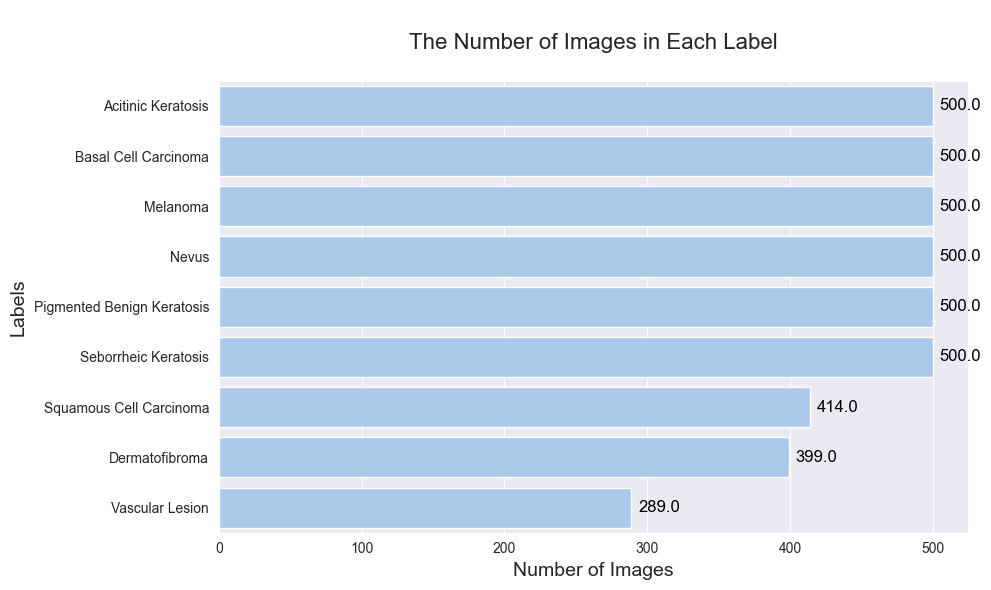

In [8]:
# Display the count of each label in the dataset
label_counts = pd.Series(root_labels).value_counts()
print(label_counts)

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a horizontal countplot with a more appealing color palette
sns.set_palette("pastel")
count_plot = sns.countplot(y=pd.Series(root_labels), order=label_counts.index)

# Add title and labels
plt.title("\nThe Number of Images in Each Label\n",  fontsize=16)
plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Labels", fontsize=14)

# Add data labels to each bar for better interactivity
for p in count_plot.patches:
    count_plot.annotate(
        p.get_width(), 
        (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center', 
        fontsize=12, color='black', 
        xytext=(5, 0), 
        textcoords='offset points'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


  # Data Augmentation using MixUp
    MixUp is an effective technique for data augmentation that increases the diversity of training datasets by generating synthetic samples. 
    This method enhances the robustness and generalization of models by facilitating learning from a wider variety of examples, which ultimately 
    results in improved performance on previously unseen data.



  # Encode Datasets


In [9]:
# Convert the list of root_images to a NumPy array
x_arr = np.array(root_images)

# Convert root_labels to one-hot encoded format
# For each label in root_labels, find its index in the classes list
# Create one-hot encoded labels for the number of classes
y_arr = tf.one_hot(
    [classes.index(label) for label in root_labels], 
    num_classes
).numpy()  # Convert the tensor to a NumPy array

# Output the shapes of x_arr and y_arr
x_arr.shape, y_arr.shape

((4102, 224, 224, 3), (4102, 9))

In [10]:
# Convert the NumPy array of images to a TensorFlow constant tensor with float32 data type
x_tensor = tf.constant(x_arr, dtype=tf.float32)

# Create a one-hot encoded tensor for the labels using the index of each label in the classes list
y_tensor = tf.one_hot(
    indices=[classes.index(label) for label in root_labels],  # Get the index of each label
    depth=num_classes  # Specify the number of classes for one-hot encoding
)

# Display the shapes of the input tensor and the one-hot encoded tensor
x_tensor.shape, y_tensor.shape

(TensorShape([4102, 224, 224, 3]), TensorShape([4102, 9]))

In [11]:
# Number of images desired per class
image_per_class = 1000

# Number of mixed images per batch
mix_per_batch = 42

# Initialize the MixUp augmenter
mixup = keras_cv.layers.Augmenter([
    keras_cv.layers.MixUp(),
])

# Create a DataFrame to hold root labels
root_label_df = pd.DataFrame({"dx": root_labels})

# Create a dictionary to count the number of images for each label
count_dict = {label: len(images) for label, images in data_dict.items()}

# Initialize tensors to hold mixed images and labels
x_tensor_mix = None
y_tensor_mix = None

# Loop through each label and its corresponding image count
for label, count in count_dict.items():
    # Calculate how many more images are needed to reach the target
    num_mix_least = image_per_class - count

    # Calculate how many complete batches can be created
    num_batch = num_mix_least // mix_per_batch

    # Total number of mixed images to generate
    num_mix = num_batch * mix_per_batch

    print(f"Found {count} image(s) belonging to {label}. Generating {num_mix} ({num_batch} batch(s)) using mixup...")

    # Generate mixed images in batches
    for i in range(num_batch):
        # Randomly select indices from the current label's images
        indices = np.random.choice(count, mix_per_batch, replace=False)

        # Get the actual indices from the DataFrame
        real_index = root_label_df[root_label_df.dx == label].index[indices]

        # Gather the images and labels using the selected indices
        x_mix = tf.gather(x_tensor, real_index)
        y_mix = tf.gather(y_tensor, real_index)

        # Perform the MixUp operation
        mix_out = mixup({"images": x_mix, "labels": y_mix})

        # Combine the new mixed images and labels with the existing tensors
        if x_tensor_mix is None:
            x_tensor_mix = mix_out["images"]
            y_tensor_mix = mix_out["labels"]
        else:
            x_tensor_mix = tf.concat([x_tensor_mix, mix_out["images"]], axis=0)
            y_tensor_mix = tf.concat([y_tensor_mix, mix_out["labels"]], axis=0)

    # Log the completion of mixup for the current label
    print(f"Mixup complete. {label}: {count + num_mix} image(s).")

Found 500 image(s) belonging to Acitinic Keratosis. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Acitinic Keratosis: 962 image(s).
Found 500 image(s) belonging to Basal Cell Carcinoma. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Basal Cell Carcinoma: 962 image(s).
Found 399 image(s) belonging to Dermatofibroma. Generating 588 (14 batch(s)) using mixup...
Mixup complete. Dermatofibroma: 987 image(s).
Found 500 image(s) belonging to Melanoma. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Melanoma: 962 image(s).
Found 500 image(s) belonging to Nevus. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Nevus: 962 image(s).
Found 500 image(s) belonging to Pigmented Benign Keratosis. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Pigmented Benign Keratosis: 962 image(s).
Found 500 image(s) belonging to Seborrheic Keratosis. Generating 462 (11 batch(s)) using mixup...
Mixup complete. Seborrheic Keratosis: 962 image(s).
Found 41

# Visualize MixUp Dataset

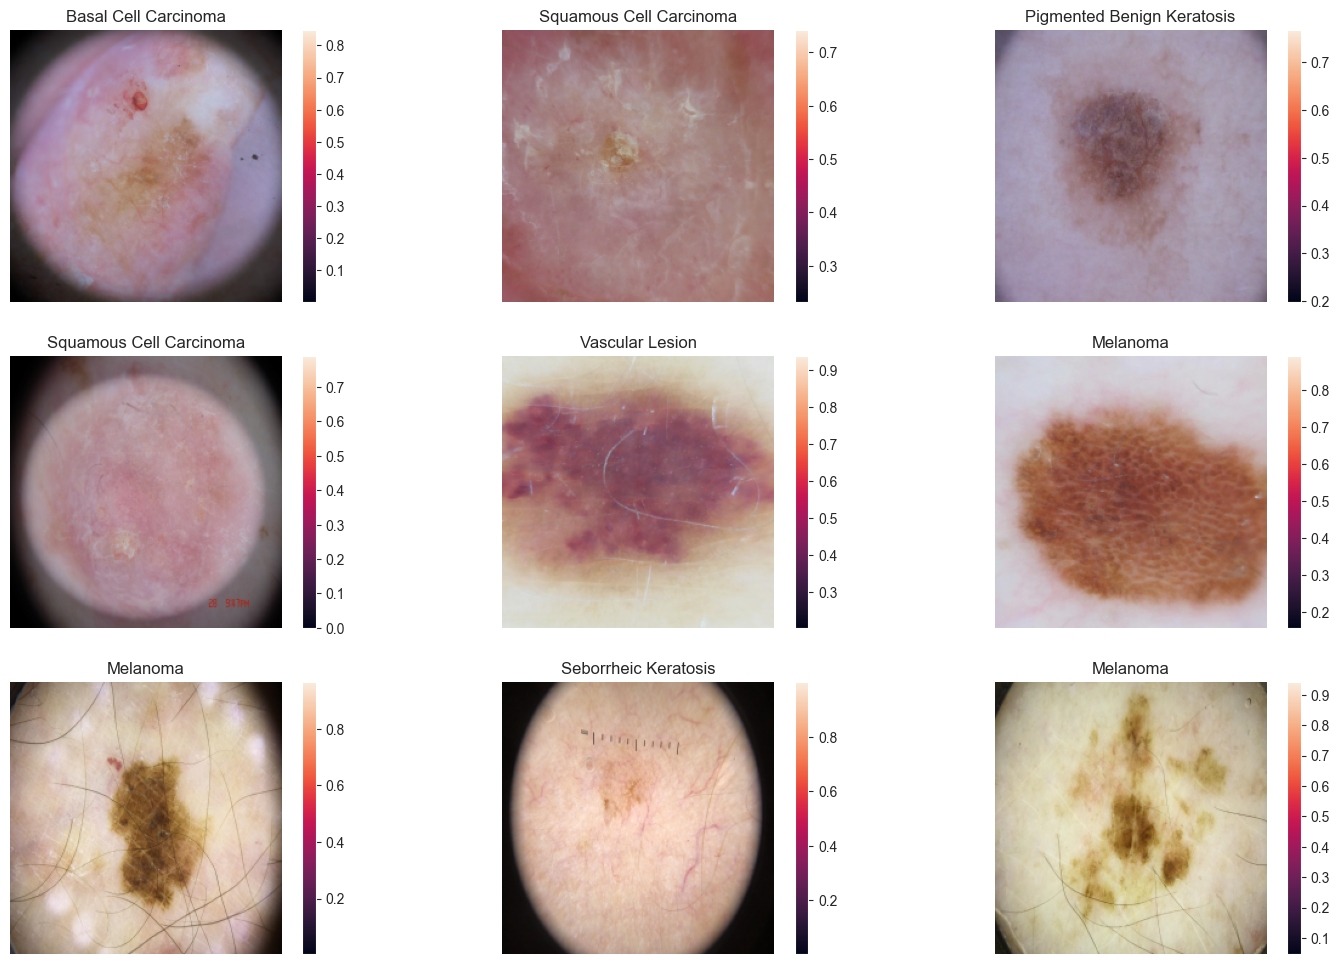

In [12]:
def visualize_datasets(images, labels, k=4, cols=4, seed=42):
    # Adjust the number of images to visualize if k exceeds available images
    if k > len(images): 
        k = len(images)
    # Calculate the number of rows needed for the grid layout
    rows = int(np.ceil(k / cols))
    # Create a figure with the specified size
    fig = plt.figure(figsize=(6 * cols, 4 * rows))
    # Loop through the images to create subplots
    for i in range(k):
        ax = fig.add_subplot(rows, cols, i + 1)
        # Set the title for each subplot
        ax.title.set_text(labels[i])
        # Display the image and normalize pixel values to [0, 1]
        plt.imshow(images[i] / 255.0)
        # Add a colorbar to the plot
        plt.colorbar()
        # Turn off the axis for a cleaner look
        plt.axis('off')
    # Show the figure with all subplots
    plt.show()

# Get the number of mixed images
mix_length = x_tensor_mix.shape[0]
# Randomly select indices to sample images
sample_indices = np.random.choice(mix_length, size=9)
# Gather sample images and their corresponding labels
sample_images = tf.gather(x_tensor_mix, sample_indices).numpy()
sample_labels = tf.gather(tf.argmax(y_tensor_mix, axis=-1), sample_indices).numpy()
# Map numerical labels to class names
sample_labels = [classes[i] for i in sample_labels]
# Visualize the sampled images and labels
visualize_datasets(sample_images, sample_labels, k=9, cols=3)


  # Merge MixUp Dataset


In [13]:
import numpy as np

# Specify the size of your dataset
num_samples = len(x_arr)  # Total number of samples in the dataset
IMG_SIZE = 224  # Example size of images
num_classes = 9  # Example number of classes

# Create a memory-mapped array for the images and labels
x_mmap = np.memmap('x_data.mmap', dtype='float32', mode='w+', shape=(num_samples, IMG_SIZE, IMG_SIZE, 3))
y_mmap = np.memmap('y_data.mmap', dtype='float32', mode='w+', shape=(num_samples, num_classes))

# Write the data to memory-mapped arrays in chunks
chunk_size = 1000  # Number of samples per chunk

for i in range(0, num_samples, chunk_size):
    # Load the chunk of images and labels
    x_chunk = np.array(x_arr[i:i + chunk_size])
    y_chunk = np.array(y_arr[i:i + chunk_size])

    # Write the chunk to memory-mapped files
    x_mmap[i:i + chunk_size] = x_chunk
    y_mmap[i:i + chunk_size] = y_chunk

# Now the data can be accessed directly from the disk using x_mmap and y_mmap, without using a lot of memory


Acitinic Keratosis            500
Basal Cell Carcinoma          500
Melanoma                      500
Nevus                         500
Pigmented Benign Keratosis    500
Seborrheic Keratosis          500
Squamous Cell Carcinoma       414
Dermatofibroma                399
Vascular Lesion               289
Name: count, dtype: int64


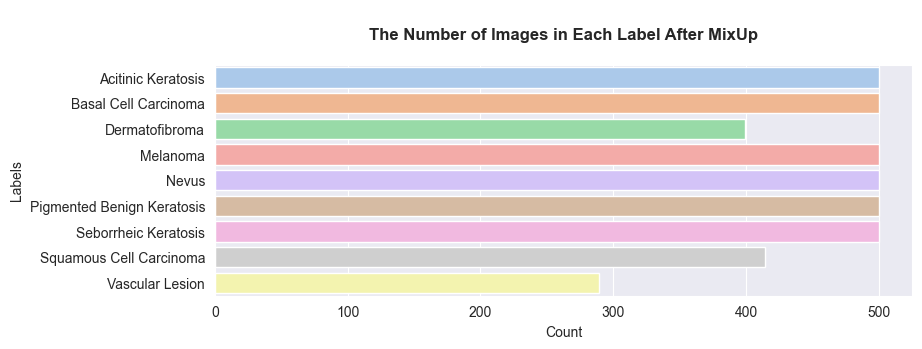

In [14]:
# After successfully merging data, you can proceed with this
mixed_labels = [classes[i] for i in np.argmax(y_mmap, axis=1)]

# Display the count of each label
label_counts = pd.Series(mixed_labels).value_counts()
print(label_counts)

# Visualize the distribution of labels
plt.figure(figsize=(9, 3))
sns.countplot(y=pd.Series(mixed_labels), hue=pd.Series(mixed_labels), palette='pastel', legend=False)
plt.title("\nThe Number of Images in Each Label After MixUp\n", weight="bold")
plt.xlabel("Count")
plt.ylabel("Labels")
plt.show()



  # Training and Testing Dataset


In [15]:
# Assigning the merged mixed dataset to x
x = x_mmap  # Merged mixed input images

# Assigning the corresponding labels to y
y = y_mmap  # Merged mixed labels

In [16]:
# Get the number of samples
num_samples = len(x)

# Split indices for training, validation, and test
train_size = int(0.8 * num_samples)   # 80% for training
val_size = int(0.5 * (num_samples - train_size))  # 50% of the remaining 20% for validation
test_size = num_samples - train_size - val_size  # Remaining for testing

# Create the splitsdirpath
x_train = x[:train_size]
x_val = x[train_size:train_size + val_size]
x_test = x[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

# Display the shapes of the training, validation, and test sets
shapes = [
    x_train.shape, 
    x_val.shape, 
    x_test.shape, 
    y_train.shape, 
    y_val.shape,
    y_test.shape
]

shapes


[(3281, 224, 224, 3),
 (410, 224, 224, 3),
 (411, 224, 224, 3),
 (3281, 9),
 (410, 9),
 (411, 9)]


  # Helper Functions


In [17]:
def plot_acc(model_history, name):
    # Update the font size for better readability
    plt.rcParams.update({'font.size': 14})

    # Print new lines for spacing in the output
    print('\n\n')

    # Calculate the number of epochs from the model history
    epochs = len(model_history.history["accuracy"])

    # Create a new figure for plotting
    plt.figure(figsize=(12, 8))

    # Plot training accuracy
    plt.plot(np.arange(0, epochs), model_history.history["accuracy"], 
             label="Training Accuracy", marker="o", color='blue')

    # Plot validation accuracy
    plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], 
             label="Validation Accuracy", marker="o", color='orange')

    # Set the title of the plot with the model name
    plt.title("Training Accuracy - {}".format(name))

    # Label the x-axis
    plt.xlabel("Epoch")

    # Label the y-axis
    plt.ylabel("Accuracy")

    # Display the legend to identify training and validation accuracy
    plt.legend()

    # Show the plot
    plt.show()

In [18]:
def plot_loss(model_history, name):
    # Update font size for plots
    plt.rcParams.update({'font.size': 14})
    
    # Print new lines for better separation in console output
    print('\n\n')
    
    # Determine the number of epochs from the model history
    epochs = len(model_history.history["loss"])
    
    # Create a figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot training loss
    plt.plot(np.arange(0, epochs), 
             model_history.history["loss"], 
             label="train_loss", 
             marker="o")
    
    # Plot validation loss
    plt.plot(np.arange(0, epochs), 
             model_history.history["val_loss"], 
             label="val_loss", 
             marker="o")
    
    # Set plot title and labels
    plt.title(f"Training Loss - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    # Show legend and display the plot
    plt.legend()
    plt.show()

In [19]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Update font size for better readability
    plt.rcParams.update({'font.size': 14})
    
    # Determine the number of classes
    class_count = len(classes)
    
    # Normalize the confusion matrix if required
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    # Create a new figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=cmap, cbar=False)
    
    # Set x-ticks and y-ticks
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0)
    
    # Label the axes
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Set the title of the plot
    plt.title(title)
    
    # Show the plot
    plt.show()

In [20]:
def evaluate(model, x, y):
    scores = model.evaluate(x, y, verbose=1)
    return scores

In [21]:
def predict_prob(model):
    return model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

In [22]:
def predict(model):
    predictions = predict_prob(model)
    return np.argmax(predictions, axis=1)

In [23]:
def calculate_metrics(y_true, y_pred):
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision: {}".format(precision))

    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:    {}".format(recall))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1:        {}".format(f1))


  # Setting up Model Training


In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

In [25]:
def transfer_learning(model, name, epochs=50):
    
    best_weights_ph1 = f"/kaggle/working/{name}_ph1_weights.weights.h5"
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Create an ImageDataGenerator for rescaling
    train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
    val_datagen = ImageDataGenerator(rescale=1./255)    # Rescale pixel values for validation data

    # Create data generators for training and validation
    train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
    val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph1,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
        ]
    )
    
    print("Model summary for transfer learning: ")
    print("Total params: {:.2f}M".format(sum(layer.count_params() for layer in model.layers) / 1e6))
    print("Trainable params: {:.2f}M".format(sum(layer.count_params() if layer.trainable else 0 for layer in model.layers) / 1e6))
    print("Non-Trainable params: {:.2f}M".format(sum(layer.count_params() if not layer.trainable else 0 for layer in model.layers) / 1e6))
    
    history = model.fit(
        train_generator,  # Use the generator for training data
        validation_data=val_generator,  # Use the generator for validation data
        epochs=epochs,
        callbacks=[callbacks_checkpoint]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx + 1))
    
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('\nRestoring best weights and predicting validation set.')
    model.load_weights(best_weights_ph1)
    model.save(f"{dataset_name}_{name}_ph1_model.h5")
    
    loss, acc, *other_acc = evaluate(model, x_test, y_test)
    print('Transfer Learning test scores (loss, acc):', [loss, acc])
    plot_acc(history, f"\n Transfer Learning - ACC: {name} PhA.")
    plot_loss(history, f"\n Transfer Learning - LOSS: {name} PhA.")
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

In [26]:
def fine_tuning(model, name, acc_ph1=0, epochs=60):
    
    best_weights_ph2 = "/kaggle/working/ResNet50_ph2.weights.h5"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph2, 
        monitor = "val_accuracy", 
        mode = "max",
        initial_value_threshold=acc_ph1,
        save_weights_only=True, 
        save_best_only = True, 
        verbose=1, # Logging when callback running
    )
    
    model.trainable = True
#     for layer in model.layers:
#         if not isinstance(layer, layers.BatchNormalization) and not isinstance(layer, layers.LayerNormalization):
#             layer.trainable = True
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
        ]
    )
    print("Model summary for fine tuning: ")
    print("Total params: {:.2f}M".format(sum(layer.count_params() for layer in model.layers) / 1e6))
    print("Trainable params: {:.2f}M".format(sum(layer.count_params() if layer.trainable else 0 for layer in model.layers) / 1e6))
    print("Non-Trainable params: {:.2f}M".format(sum(layer.count_params() if not layer.trainable else 0 for layer in model.layers) / 1e6))
    
    history = model.fit(
        x_train, 
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = epochs,
        callbacks = [callbacks_checkpoint, 
                     early_stop
                    ]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx))
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('Restoring best weights of Ph2 and predicting test set.')
    model.load_weights(best_weights_ph2)
    model.save(f"{name}_ph2_model.h5")
    
    loss, acc, *other_acc = evaluate(model, x_test, y_test)
    print('Fine Tuning test scores (loss, acc):', [loss, acc])
    
    if val_acc_max < acc_ph1:
        print('\nPhase 2 resulted in lower accuracy than Phase 1.')
    
    plot_acc(history, f"\n Fine Tuning - ACC: {name} PhB.")
    plot_loss(history, f"\n Fine Tuning - LOSS: {name} PhB.")
    
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

In [27]:
def save_history(history, path):
    history_df = pd.DataFrame(data=history)
    history_df.index.name = "Epoch"
    history_df.to_csv(path)
    print("Saved history completed.")


  # Building Model VGG19


In [28]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers

# Load the VGG19 model with pre-trained ImageNet weights
vgg19 = VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
vgg19.trainable = False

# Function to build the model with the pre-trained model as input
def build_model(pre_trained_model):
    
    x_input = pre_trained_model.input
    x = pre_trained_model.output
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.GlobalAvgPool2D()(x)  # Apply Global Average Pooling on the 4D output
    output = layers.Dense(9, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='VGG19_V1')


# Create the model using VGG19 as the pre-trained base
vgg19_v1 = build_model(vgg19)
print(f"{vgg19_v1.name}: {len(vgg19_v1.layers)} layers. {(sum(layer.count_params() for layer in vgg19_v1.layers) / 1e6):.2f}M params.")

VGG19_V1: 25 layers. 20.56M params.



  # Test and Visualize Results